**This notebook is created by
TEJAS MISTRY,
CHANDRAJEETSINH CHUDASAMA, PUSHAN PARIHAR**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

# LOAD THE DATASET

In [ ]:
df = pd.read_csv('goldstock.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Date        2511 non-null   object 
 2   Close       2511 non-null   float64
 3   Volume      2511 non-null   float64
 4   Open        2511 non-null   float64
 5   High        2511 non-null   float64
 6   Low         2511 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.4+ KB


#DROPPING THE UNECESSARY COLUMN

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# TRANSFORMING THE DATA

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Check for duplicates and missing values

In [ ]:
df.duplicated().sum()
df.isnull().sum().sum()

0

# Visualizing Gold Price History Data

In [ ]:
fig = px.line(y=df.Close, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

# Splitting Data to Training & Test Sets

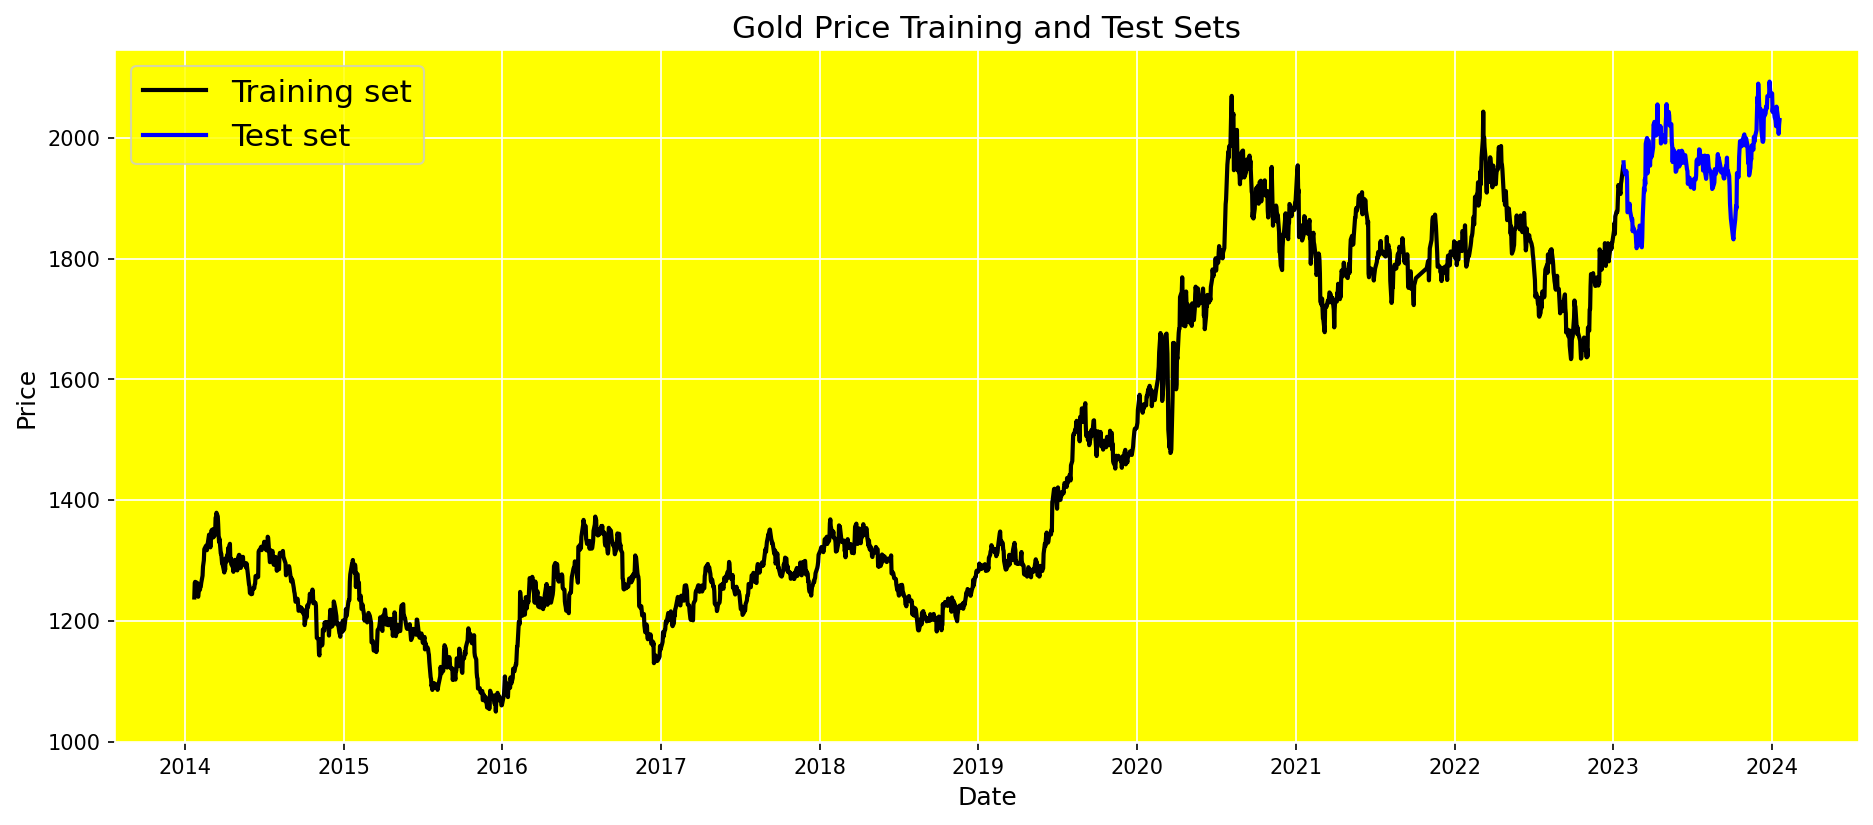

In [ ]:
test_size = df[df.Date.dt.year==2022].shape[0]

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Close[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Close[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Data scaling

In [ ]:

scaler = MinMaxScaler()
scaler.fit(df.Close.values.reshape(-1,1))

MinMaxScaler()


# Restructure Data & Create Sliding Window

In [ ]:
window_size = 60
train_data = df.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))
X_train = []
y_train = []

In [ ]:
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
test_data = df.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))
X_test = []
y_test = []

In [ ]:
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Convert Data to Numpy Arrays

In [ ]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [ ]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2203, 60, 1)
y_train Shape:  (2203, 1)
X_test Shape:   (248, 60, 1)
y_test Shape:   (248, 1)


# Creating an LSTM Network

In [ ]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [ ]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

# Model Evaluation

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

8/8 [==============================] - 1s 5ms/step


In [ ]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0010205870494246483
Test MAPE: 0.027495405123115695
Test Accuracy: 0.9725045948768843


In [ ]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

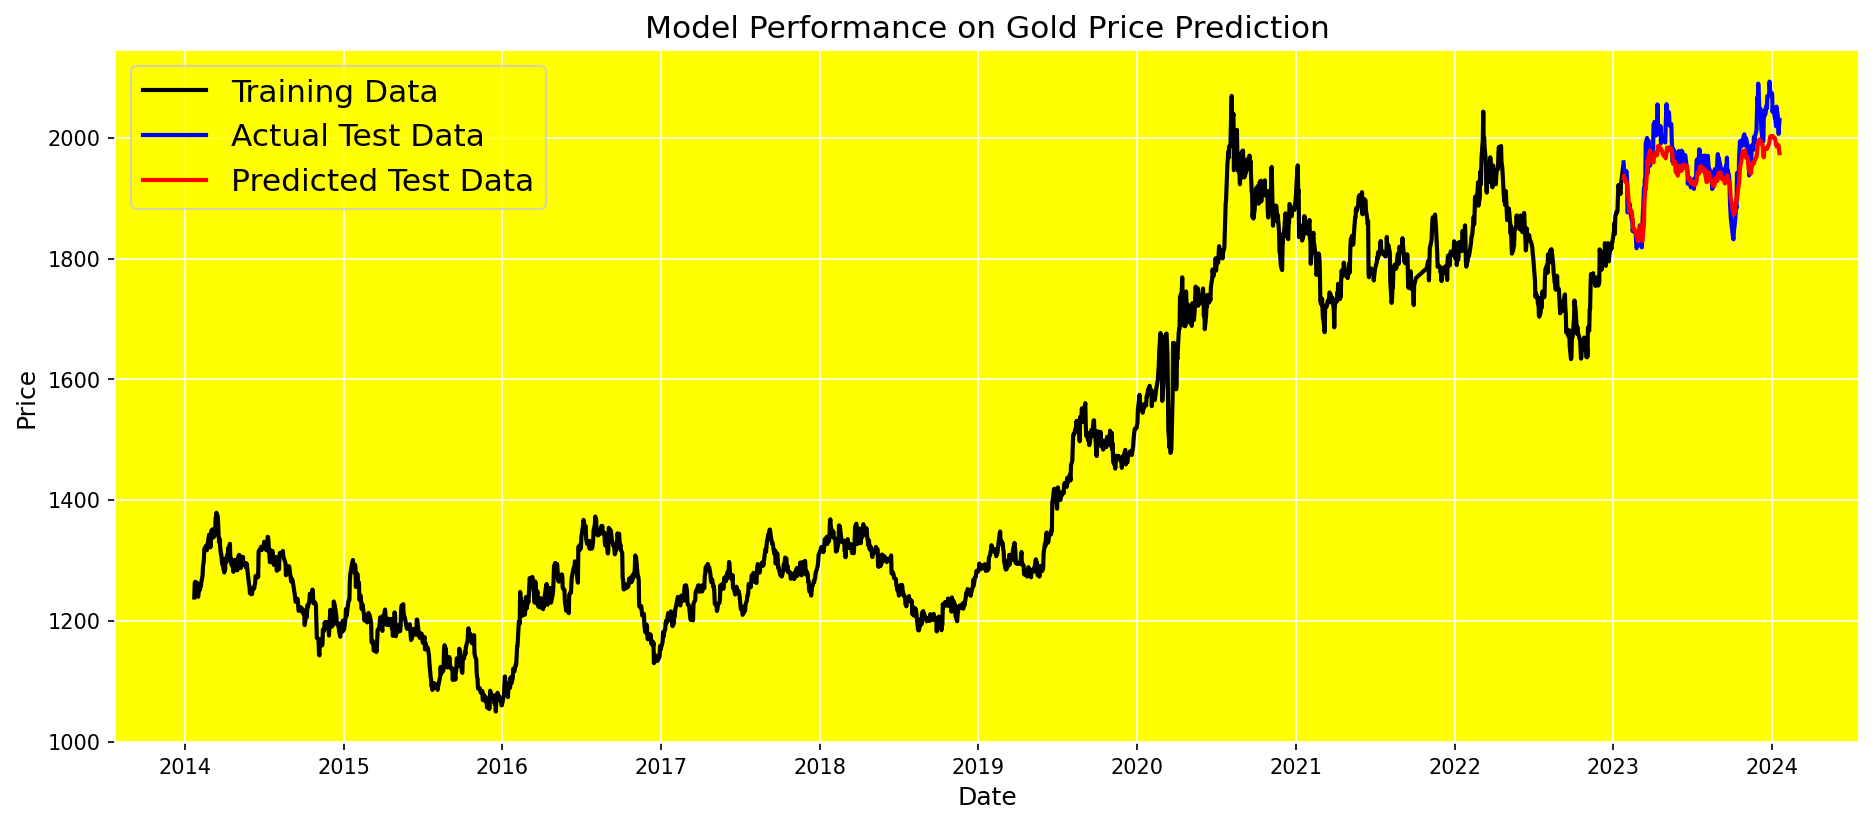

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Define GRU-based model

In [ ]:
from keras.layers import GRU


def define_gru_model():
    input1 = Input(shape=(window_size,1))
    x = GRU(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = GRU(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = GRU(units=64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model


In [ ]:
gru_model = define_gru_model()
gru_history = gru_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 gru (GRU)                   (None, 60, 64)            12864     
                                                                 
 dropout_3 (Dropout)         (None, 60, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 60, 64)            24960     
                                                                 
 dropout_4 (Dropout)         (None, 60, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0   

# Evaluate GRU model

8/8 [==============================] - 1s 5ms/step
GRU Test Loss: 0.0007475968450307846
GRU Test MAPE: 0.021801173674853676
GRU Test Accuracy: 0.9781988263251463


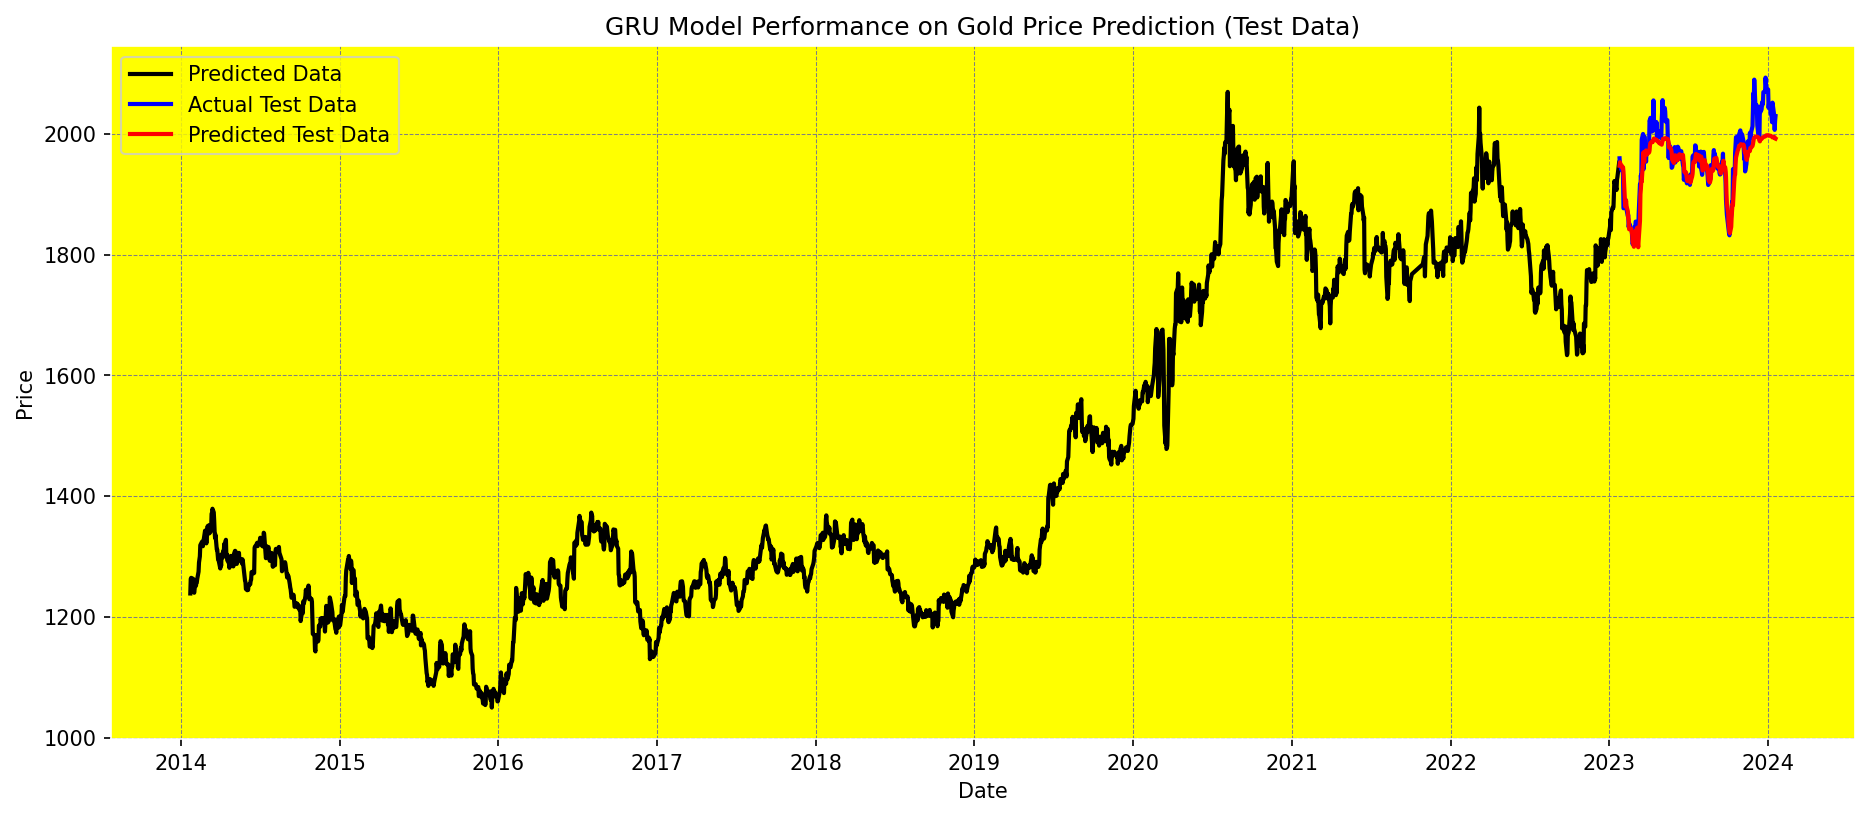

In [ ]:

test_size = df[df.Date.dt.year==2022].shape[0]
gru_result = gru_model.evaluate(X_test, y_test)
gru_y_pred = gru_model.predict(X_test)
gru_MAPE = mean_absolute_percentage_error(y_test, gru_y_pred)
gru_Accuracy = 1 - gru_MAPE

print("GRU Test Loss:", gru_result)
print("GRU Test MAPE:", gru_MAPE)
print("GRU Test Accuracy:", gru_Accuracy)

# Inverse transform predictions for visualization
gru_y_pred_inv = scaler.inverse_transform(gru_y_pred)

# Plot actual vs. predicted prices for GRU model on test data
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], gru_y_pred_inv, color='red', lw=2)
plt.title('GRU Model Performance on Gold Price Prediction (Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Predicted Data','Actual Test Data', 'Predicted Test Data'], loc='upper left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()


# Define CNN-based model

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten


def define_cnn_model():
    input1 = Input(shape=(window_size,1))
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(input1)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(50, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model


In [ ]:
cnn_model = define_cnn_model()
cnn_history = cnn_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 58, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 832)               0   

# Evaluate CNN model

8/8 [==============================] - 0s 2ms/step
CNN Test Loss: 0.0009525919449515641
CNN Test MAPE: 0.028012260963985645
CNN Test Accuracy: 0.9719877390360143


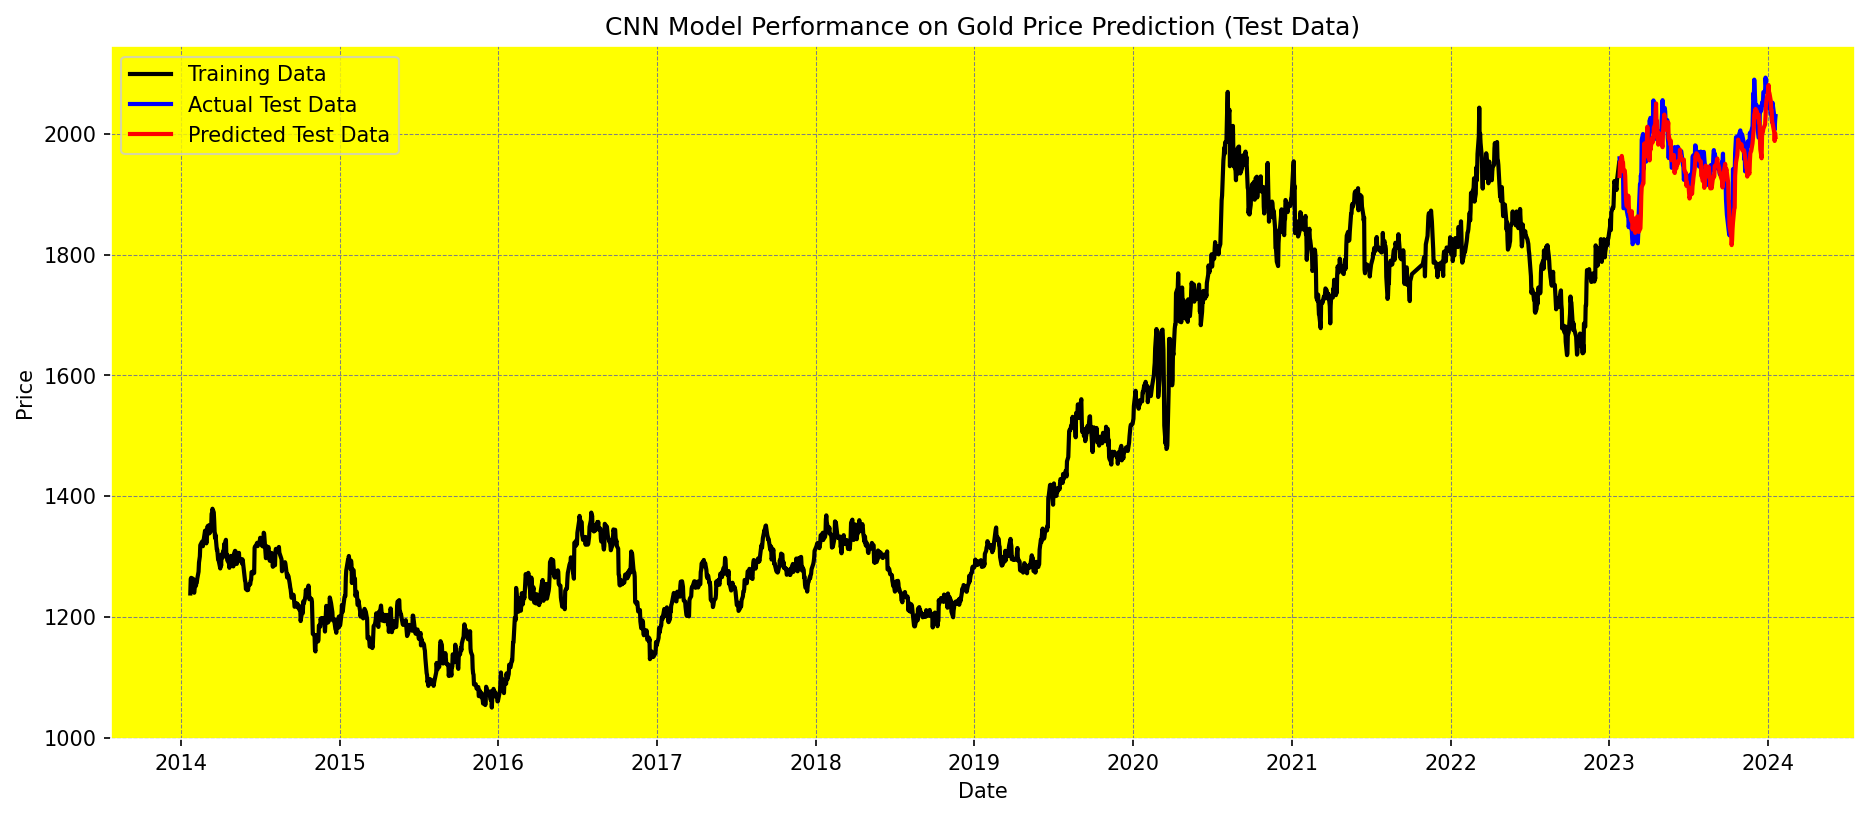

In [ ]:
cnn_result = cnn_model.evaluate(X_test, y_test)
cnn_y_pred = cnn_model.predict(X_test)
cnn_MAPE = mean_absolute_percentage_error(y_test, cnn_y_pred)
cnn_Accuracy = 1 - cnn_MAPE

print("CNN Test Loss:", cnn_result)
print("CNN Test MAPE:", cnn_MAPE)
print("CNN Test Accuracy:", cnn_Accuracy)

# Inverse transform predictions for visualization
cnn_y_pred_inv = scaler.inverse_transform(cnn_y_pred)

# Plot actual vs. predicted prices for CNN model on test data
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], cnn_y_pred_inv, color='red', lw=2)
plt.title('CNN Model Performance on Gold Price Prediction (Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Training Data','Actual Test Data', 'Predicted Test Data'], loc='upper left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()


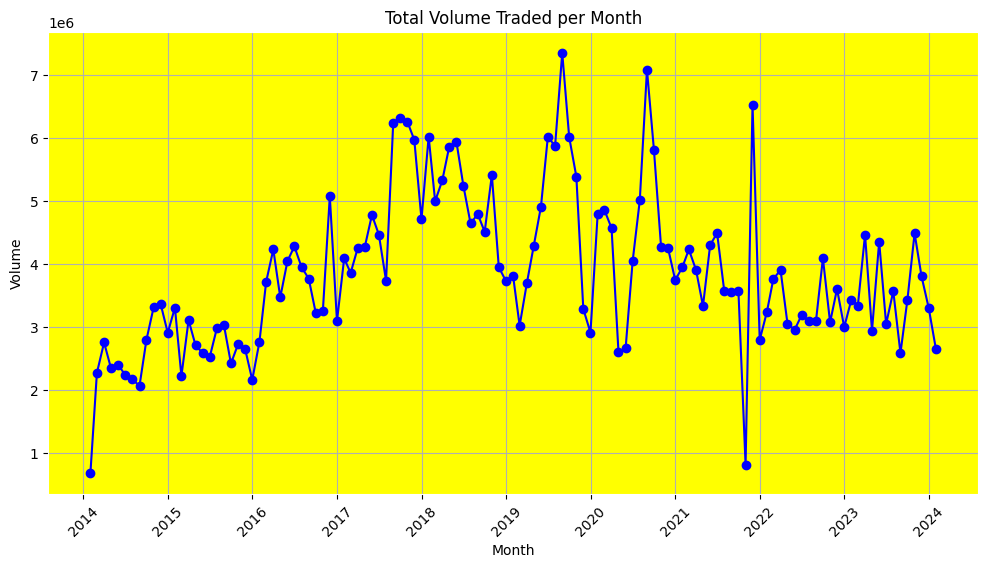

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('goldstock.csv')


df['Date'] = pd.to_datetime(df['Date'])

monthly_volume = df.groupby(pd.Grouper(key='Date', freq='M'))['Volume'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_volume['Date'], monthly_volume['Volume'], marker='o', color='blue')
plt.title('Total Volume Traded per Month')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
